In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, RepeatedKFold

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

In [2]:
df = pd.read_csv('data/Model Test Data.csv')

Just check the distribution of each feature.

In [3]:
df.describe()

,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,12.190351,8445.963010,3450.252510,168505.815510,1.610510,73390.402240,85873.402570,1.150636e+06,22190.066240,153862.395490,3.032500
std,16.020137,3540.407793,2544.552718,154606.758685,0.799212,42488.751840,71600.020020,8.840513e+05,9835.270071,84665.459925,1.410901
min,-20.486397,-5583.153749,-6338.250221,-439972.812600,-1.328607,-77050.448580,-162312.422300,-2.692945e+06,-12674.425590,-135125.465700,1.000000
25%,0.342919,6012.666381,1689.792306,64840.482335,1.070263,44707.280773,37958.405845,5.353268e+05,15593.819880,96818.711418,2.000000
50%,10.881019,8463.373285,3430.595021,167029.781400,1.598712,73543.761555,86582.980525,1.149984e+06,22091.102400,154089.232450,3.000000
75%,23.047831,10864.843605,5165.408836,272343.174250,2.146489,102189.829900,133951.621325,1.742196e+06,28924.445840,211875.685575,4.000000
max,94.749833,23299.976630,12288.699000,857156.728100,4.639956,242913.447400,357758.526300,4.315470e+06,58807.189120,473752.797700,5.000000


And here starts interesting moments.
var_1, var_3, var_5, var_6 have near linear dependency with target variable. var_2, var_9 and var_10 have non-linear dependency with target, so Linear or even polynomial regression can't predict this dependence.

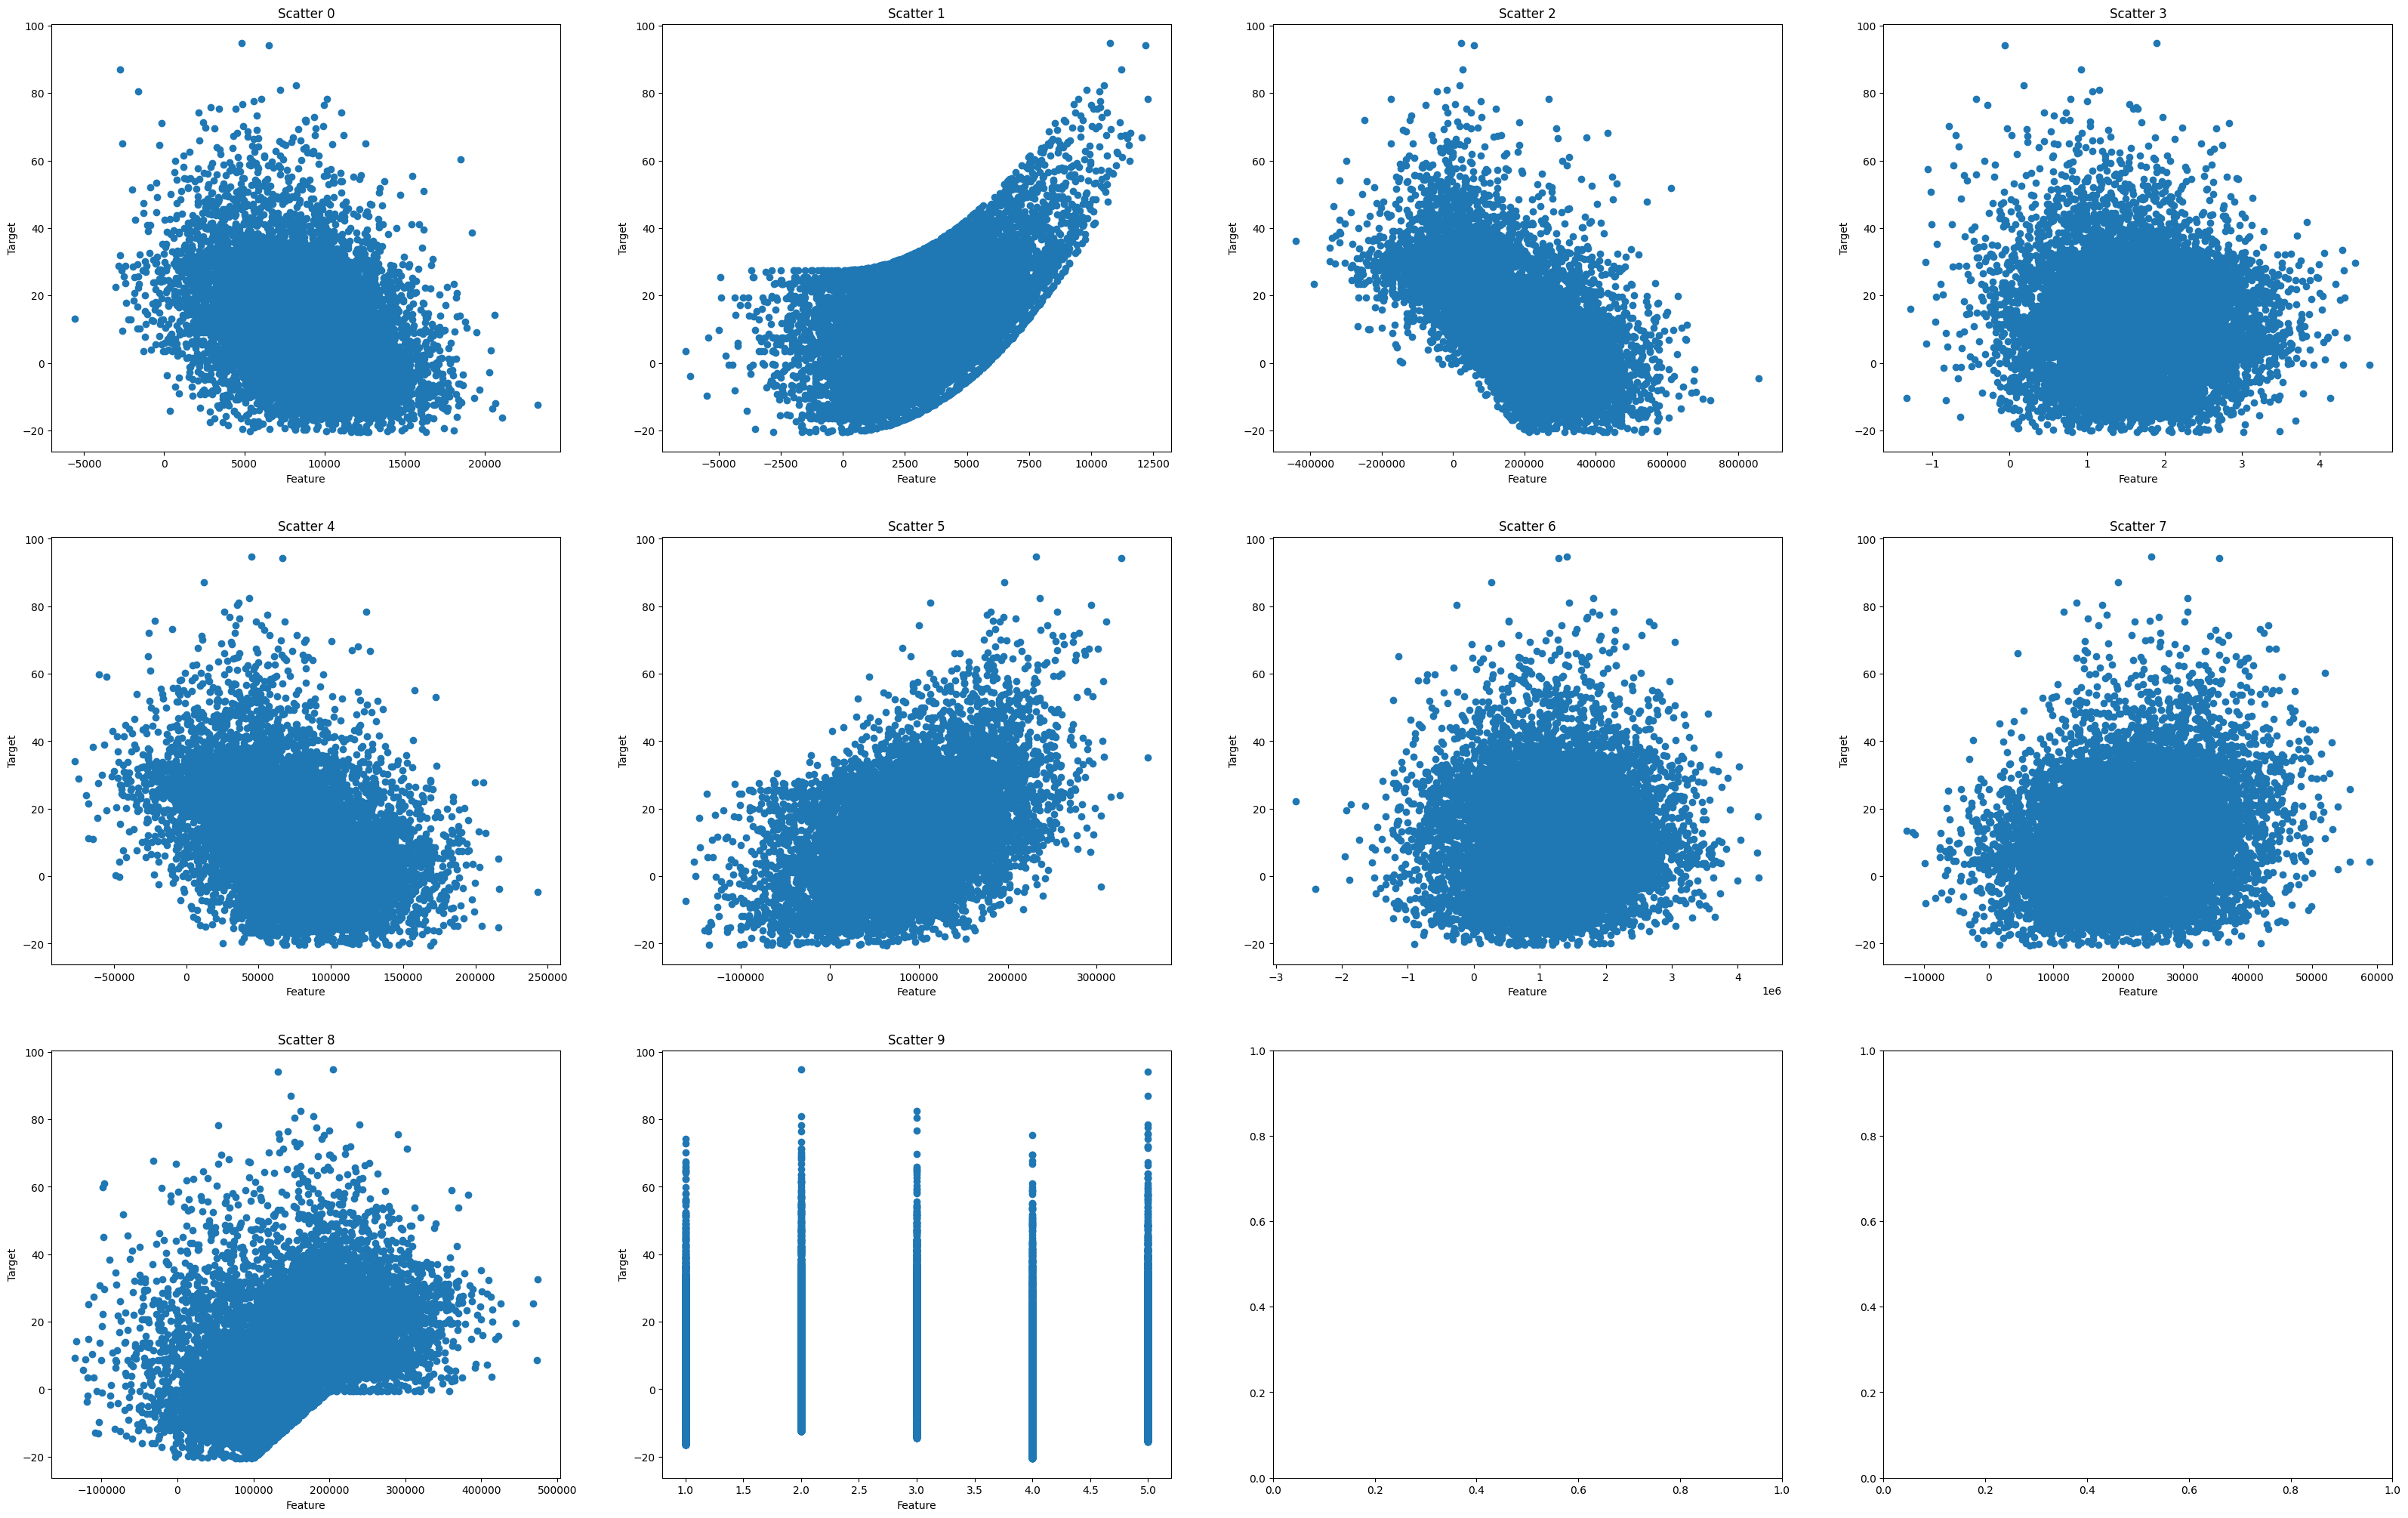

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(40, 25))

for i, col in enumerate(df.columns[1:]):
    ax[i // 4][i % 4].scatter(df[col], df['y'])
    ax[i // 4][i % 4].set_xlabel('Feature')
    ax[i // 4][i % 4].set_ylabel('Target')
    ax[i // 4][i % 4].set_title(f'Scatter {i}')
plt.show()

Correlation heatmap proves my upper decision. corr(var_10, y) = -0.05 because of non-linear dependency.

In [5]:
df.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
y,1.00,-0.34,0.50,-0.60,-0.05,-0.40,0.43,0.03,0.19,0.38,-0.05
var_1,-0.34,1.00,-0.14,0.20,-0.25,0.19,-0.17,0.47,0.21,-0.34,0.02
var_2,0.50,-0.14,1.00,0.03,-0.36,-0.04,0.60,-0.03,0.21,-0.37,0.00
var_3,-0.60,0.20,0.03,1.00,0.04,0.81,0.04,0.23,-0.28,-0.41,-0.01
var_4,-0.05,-0.25,-0.36,0.04,1.00,-0.08,-0.19,0.08,-0.04,0.47,-0.00
var_5,-0.40,0.19,-0.04,0.81,-0.08,1.00,0.28,0.30,-0.41,-0.05,-0.01
var_6,0.43,-0.17,0.60,0.04,-0.19,0.28,1.00,0.05,0.10,0.10,-0.01
var_7,0.03,0.47,-0.03,0.23,0.08,0.30,0.05,1.00,-0.01,0.31,0.01
var_8,0.19,0.21,0.21,-0.28,-0.04,-0.41,0.10,-0.01,1.00,-0.15,0.02
var_9,0.38,-0.34,-0.37,-0.41,0.47,-0.05,0.10,0.31,-0.15,1.00,-0.01


Specify features list, based on found information. This features brings decreasing of entropy in the process of building decision trees.

In [6]:
feature_list = ['var_1', 'var_2', 'var_3', 'var_5', 'var_6', 'var_9', 'var_10']

Try different models, evaluate results by mean and std values of mean squared errors cross-validation list

In [7]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=0)
cv = RepeatedKFold(n_splits=5, n_repeats=3)
scores = -cross_val_score(model, df[feature_list], df['y'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))
print(scores)

Mean MAE: 0.410 (0.139)
[0.40690742 0.50246629 0.49996535 0.35234853 0.27505289 0.41557995
 0.59508971 0.30970705 0.21190743 0.36121035 0.19698428 0.72458659
 0.37918055 0.36208993 0.55174741]


In [8]:
from xgboost import XGBRegressor

model = XGBRegressor()
cv = RepeatedKFold(n_splits=5, n_repeats=3)
scores = -cross_val_score(model, df[feature_list], df['y'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))
print(scores)

Mean MAE: 1.135 (0.161)
[1.17610374 1.16614854 0.9439688  1.25145264 1.06998062 1.07414008
 1.09803928 1.03914614 1.08287187 1.56630563 1.0793414  0.90233182
 1.11088595 1.3939341  1.07568374]


In [9]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=5, n_repeats=3)
scores = -cross_val_score(model, df[feature_list], df['y'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))
print(scores)

Mean MAE: 0.867 (0.148)
[0.76733088 0.86076044 0.90673373 1.01197298 0.74709755 1.03816676
 0.74337177 1.02784312 0.80876348 0.81960042 0.68929407 0.7456964
 1.04296556 1.15089176 0.6497514 ]


Summary:

In the process of EDA were found that some features have near linear dependence with target variable, some features have near quadratic dependence with target and some features have non-linear dependence with target. Correlation heatmap proves this.
Based on this statement was formed decision, that for this dataframe algorithms such as linear/polynomial/logistic regression or NN will show so high performance as trees.
To achieve statistics correctness were chosen cross-validation technique with MAE metric, which provide opportunity to compare different models.
As a result CatBoost shows best values, but std is quite big, so this model could show quite bigger error at the test data, but still smaller than another models.